# Transformers Classification

### 1. Setup and Installation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
sns.set_style('darkgrid')

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EvalPrediction
)
from tqdm.auto import tqdm
from datasets import Dataset as HFDataset

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report
)
from sklearn.preprocessing import LabelEncoder

In [4]:
import time
import os

from dotenv import load_dotenv
ENV_PATH = os.path.join(os.path.dirname(os.getcwd()), '.env')
load_dotenv(ENV_PATH)

import warnings
warnings.filterwarnings('ignore')

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### 2. Load and Prepare the Data

In [6]:
DATA_PATH = os.path.join(os.getcwd(), 'data', 'RHMD_Engineered.csv')
df = pd.read_csv(DATA_PATH)

In [7]:
df['combined_text'] = df['title'] + " " + df['text']

In [8]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['subreddit'])

In [9]:
for i, subreddit in enumerate(label_encoder.classes_):
    print(f"{subreddit} -> {i}")

Anxiety -> 0
SuicideWatch -> 1
depression -> 2
lonely -> 3
mentalhealth -> 4


In [10]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['label'])

In [11]:
print(f"Training set shape: {train_df.shape}")
print(f"Validation set shape: {val_df.shape}")
print(f"Testing set shape: {test_df.shape}")

Training set shape: (13027, 42)
Validation set shape: (3257, 42)
Testing set shape: (4071, 42)


### 3. Making Dataset Classes for Huggingface Transformers

In [12]:
train_dataset = HFDataset.from_pandas(train_df[['combined_text', 'label']])
val_dataset = HFDataset.from_pandas(val_df[['combined_text', 'label']])
test_dataset = HFDataset.from_pandas(test_df[['combined_text', 'label']])

In [13]:
def preprocess_function(examples, tokenizer, max_length=512):
    return tokenizer(
        examples['combined_text'],
        truncation=True,
        padding='max_length',
        max_length=max_length
    )

### 4. Classifier using BERT

In [ ]:
access_token = access_token = os.environ.get("ACCESS_TOKEN")

bert_model_name = "mental/mental-bert-base-uncased"
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name, token=access_token)

tokenizer_config.json:   0%|          | 0.00/321 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [15]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [16]:
tokenized_train_dataset = train_dataset.map(
    lambda examples: preprocess_function(examples, bert_tokenizer),
    batched=True
)
tokenized_val_dataset = val_dataset.map(
    lambda examples: preprocess_function(examples, bert_tokenizer),
    batched=True
)
tokenized_test_dataset = test_dataset.map(
    lambda examples: preprocess_function(examples, bert_tokenizer),
    batched=True
)


Map:   0%|          | 0/13027 [00:00<?, ? examples/s]

Map:   0%|          | 0/3257 [00:00<?, ? examples/s]

Map:   0%|          | 0/4071 [00:00<?, ? examples/s]

In [17]:
training_args = TrainingArguments(
    output_dir='../results/bert',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='../logs/bert',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

In [18]:
num_labels = len(label_encoder.classes_)
bert_model = AutoModelForSequenceClassification.from_pretrained(
    bert_model_name,
    num_labels=num_labels,
    token=access_token
)

config.json:   0%|          | 0.00/639 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at mental/mental-bert-base-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
bert_trainer = Trainer(
    model=bert_model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    compute_metrics=compute_metrics,
)

In [20]:
start_time = time.time()
bert_trainer.train()
end_time = time.time()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: madhavwalia8139 (madhavwalia8139-nus) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.062800,0.932267,0.646607,0.640594,0.643925,0.646607
2,0.711600,0.946224,0.658582,0.646508,0.659716,0.658582
3,0.390300,1.121129,0.649985,0.647059,0.645551,0.649985


In [21]:
training_time = end_time - start_time
print(f"BERT training time: {training_time:.2f} seconds")

BERT training time: 3995.61 seconds


In [22]:
bert_results = bert_trainer.evaluate(tokenized_test_dataset)
print(f"BERT test results: {bert_results}")

BERT test results: {'eval_loss': 0.9712563157081604, 'eval_accuracy': 0.6561041513141734, 'eval_f1': 0.6430573040957178, 'eval_precision': 0.6507677191786179, 'eval_recall': 0.6561041513141734, 'eval_runtime': 121.5438, 'eval_samples_per_second': 33.494, 'eval_steps_per_second': 2.098, 'epoch': 3.0}


In [23]:
bert_predictions = bert_trainer.predict(tokenized_test_dataset)
bert_preds = bert_predictions.predictions.argmax(-1)
bert_labels = bert_predictions.label_ids

In [24]:
print("\nBERT Classification Report:")
print(classification_report(
    bert_labels,
    bert_preds,
    target_names=label_encoder.classes_
))


BERT Classification Report:
              precision    recall  f1-score   support

     Anxiety       0.82      0.82      0.82       872
SuicideWatch       0.58      0.77      0.66       792
  depression       0.55      0.29      0.38       755
      lonely       0.71      0.76      0.73       817
mentalhealth       0.58      0.61      0.59       835

    accuracy                           0.66      4071
   macro avg       0.65      0.65      0.64      4071
weighted avg       0.65      0.66      0.64      4071



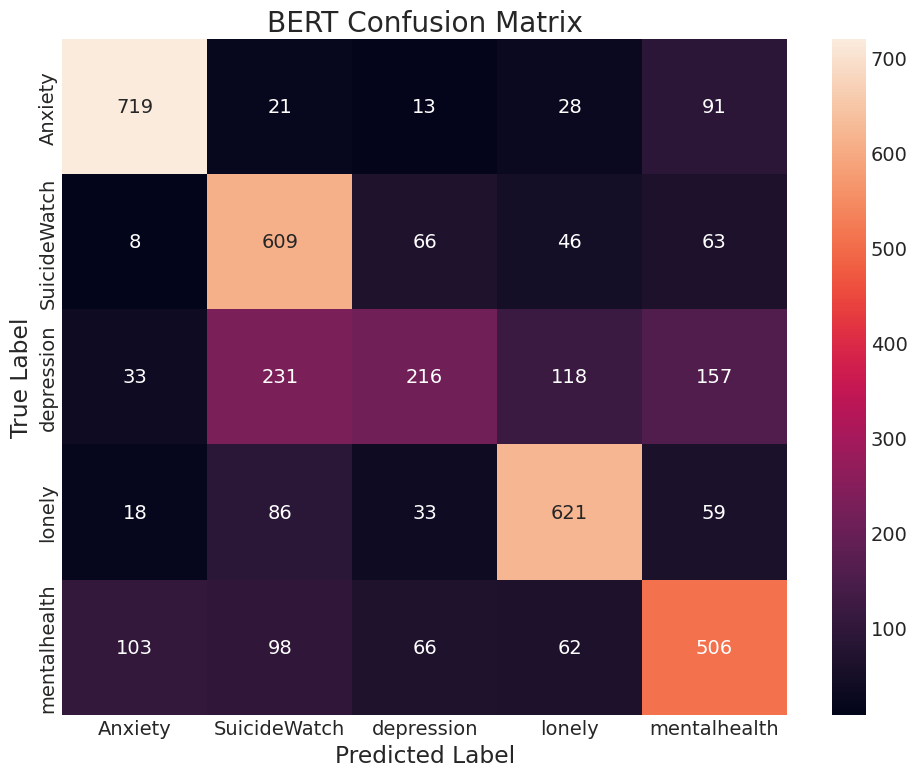

In [25]:
plt.figure(figsize=(10, 8))
cm = confusion_matrix(bert_labels, bert_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='rocket',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('BERT Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

### 5. Classifier using RoBERTa

In [27]:
roberta_model_name = "mental/mental-roberta-base"
roberta_tokenizer = AutoTokenizer.from_pretrained(roberta_model_name, token=access_token)

tokenizer_config.json:   0%|          | 0.00/327 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [28]:
tokenized_train_dataset_roberta = train_dataset.map(
    lambda examples: preprocess_function(examples, roberta_tokenizer),
    batched=True
)
tokenized_val_dataset_roberta = val_dataset.map(
    lambda examples: preprocess_function(examples, roberta_tokenizer),
    batched=True
)
tokenized_test_dataset_roberta = test_dataset.map(
    lambda examples: preprocess_function(examples, roberta_tokenizer),
    batched=True
)

Map:   0%|          | 0/13027 [00:00<?, ? examples/s]

Map:   0%|          | 0/3257 [00:00<?, ? examples/s]

Map:   0%|          | 0/4071 [00:00<?, ? examples/s]

In [29]:
training_args_roberta = TrainingArguments(
    output_dir='./results/roberta',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs/roberta',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

In [30]:
roberta_model = AutoModelForSequenceClassification.from_pretrained(
    roberta_model_name,
    num_labels=num_labels,
    token=access_token
)

config.json:   0%|          | 0.00/682 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at mental/mental-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
roberta_trainer = Trainer(
    model=roberta_model,
    args=training_args_roberta,
    train_dataset=tokenized_train_dataset_roberta,
    eval_dataset=tokenized_val_dataset_roberta,
    compute_metrics=compute_metrics,
)

In [32]:
start_time = time.time()
roberta_trainer.train()
end_time = time.time()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.076800,0.953290,0.638932,0.632569,0.641175,0.638932
2,0.819900,0.941974,0.652134,0.641420,0.647145,0.652134
3,0.536500,1.013771,0.658582,0.656447,0.655714,0.658582


In [33]:
training_time = end_time - start_time
print(f"RoBERTa training time: {training_time:.2f} seconds")

RoBERTa training time: 4007.40 seconds


In [34]:
roberta_results = roberta_trainer.evaluate(tokenized_test_dataset_roberta)
print(f"RoBERTa test results: {roberta_results}")

RoBERTa test results: {'eval_loss': 1.0443214178085327, 'eval_accuracy': 0.6465241955293539, 'eval_f1': 0.6425852156727687, 'eval_precision': 0.6398687071229092, 'eval_recall': 0.6465241955293539, 'eval_runtime': 111.964, 'eval_samples_per_second': 36.36, 'eval_steps_per_second': 2.278, 'epoch': 3.0}


In [35]:
roberta_predictions = roberta_trainer.predict(tokenized_test_dataset_roberta)
roberta_preds = roberta_predictions.predictions.argmax(-1)
roberta_labels = roberta_predictions.label_ids

In [36]:
print("\nRoBERTa Classification Report:")
print(classification_report(
    roberta_labels,
    roberta_preds,
    target_names=label_encoder.classes_
))


RoBERTa Classification Report:
              precision    recall  f1-score   support

     Anxiety       0.78      0.83      0.80       872
SuicideWatch       0.64      0.67      0.66       792
  depression       0.45      0.41      0.43       755
      lonely       0.71      0.74      0.73       817
mentalhealth       0.59      0.56      0.58       835

    accuracy                           0.65      4071
   macro avg       0.64      0.64      0.64      4071
weighted avg       0.64      0.65      0.64      4071



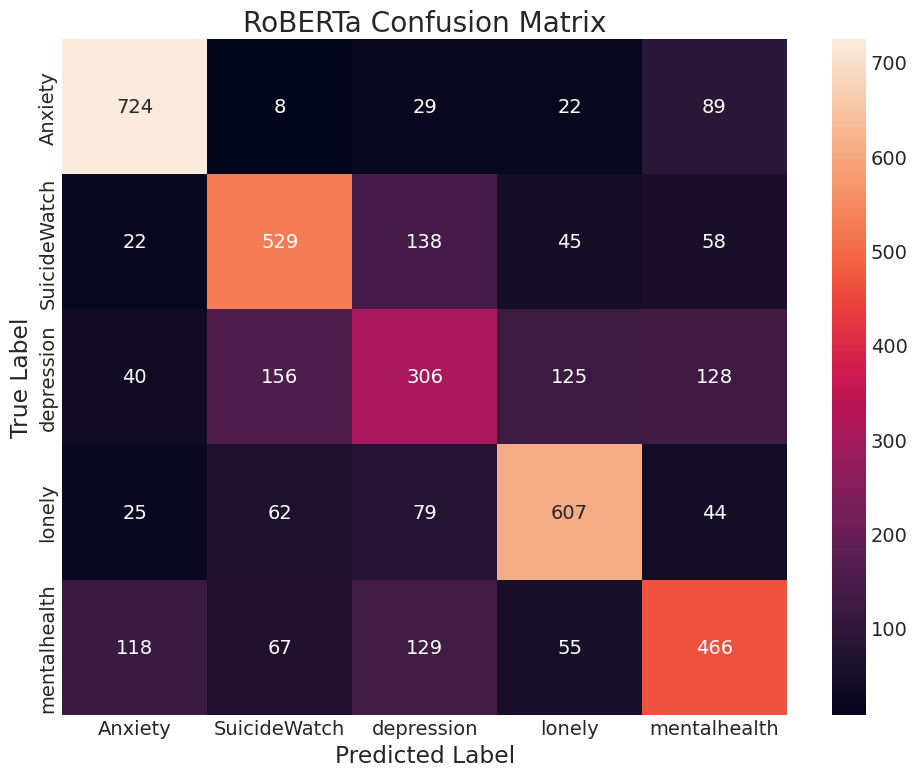

In [37]:
plt.figure(figsize=(10, 8))
cm = confusion_matrix(roberta_labels, roberta_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='rocket',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('RoBERTa Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

### 7. Error Analysis

In [38]:
def analyze_errors(texts, true_labels, predicted_labels, label_names):
    errors = []
    for i, (text, true, pred) in enumerate(zip(texts, true_labels, predicted_labels)):
        if true != pred:
            errors.append({
                'text': text,
                'true_label': label_names[true],
                'predicted_label': label_names[pred]
            })
    return pd.DataFrame(errors)

In [39]:
test_texts = test_df['combined_text'].values

In [40]:
bert_error_df = analyze_errors(
    test_texts,
    bert_labels,
    bert_preds,
    label_encoder.classes_
)

In [41]:
roberta_error_df = analyze_errors(
    test_texts,
    roberta_labels,
    roberta_preds,
    label_encoder.classes_
)

In [42]:
bert_error_patterns = bert_error_df.groupby(['true_label', 'predicted_label']).size().reset_index(name='count')
bert_error_patterns = bert_error_patterns.sort_values('count', ascending=False).head(10)
print("\nMost common BERT error patterns:")
print(bert_error_patterns)


Most common BERT error patterns:
      true_label predicted_label  count
9     depression    SuicideWatch    231
11    depression    mentalhealth    157
10    depression          lonely    118
16  mentalhealth         Anxiety    103
17  mentalhealth    SuicideWatch     98
3        Anxiety    mentalhealth     91
13        lonely    SuicideWatch     86
18  mentalhealth      depression     66
5   SuicideWatch      depression     66
7   SuicideWatch    mentalhealth     63


In [43]:
roberta_error_patterns = roberta_error_df.groupby(['true_label', 'predicted_label']).size().reset_index(name='count')
roberta_error_patterns = roberta_error_patterns.sort_values('count', ascending=False).head(10)
print("\nMost common RoBERTa error patterns:")
print(roberta_error_patterns)


Most common RoBERTa error patterns:
      true_label predicted_label  count
9     depression    SuicideWatch    156
5   SuicideWatch      depression    138
18  mentalhealth      depression    129
11    depression    mentalhealth    128
10    depression          lonely    125
16  mentalhealth         Anxiety    118
3        Anxiety    mentalhealth     89
14        lonely      depression     79
17  mentalhealth    SuicideWatch     67
13        lonely    SuicideWatch     62


In [44]:
common_errors = pd.merge(
    bert_error_df,
    roberta_error_df,
    on=['text', 'true_label'],
    how='inner',
    suffixes=('_bert', '_roberta')
)

In [45]:
print("\nSample errors that both models made:")
for i, row in common_errors.head(5).iterrows():
    print(f"\nText: {row['text'][:200]}...")
    print(f"True Label: {row['true_label']}")
    print(f"BERT Predicted: {row['predicted_label_bert']}")
    print(f"RoBERTa Predicted: {row['predicted_label_roberta']}")


Sample errors that both models made:

Text: really intense mood swing go numb almost vomiting instant multiple time day help...
True Label: Anxiety
BERT Predicted: mentalhealth
RoBERTa Predicted: mentalhealth

Text: anyone chicago room something tryna practice vocal making sad suicidal music place practice write lot lyric use practice vocal ability willing friend well like makeup skincare skating playing guita ma...
True Label: lonely
BERT Predicted: mentalhealth
RoBERTa Predicted: SuicideWatch

Text: bad started prozac routine day ago hit pause daysthats realized suicidal many year started prozac...
True Label: lonely
BERT Predicted: SuicideWatch
RoBERTa Predicted: depression

Text: get sad sometimess dm alot people college ig percent female percent guy thing many time either get left sent week either get left sent awkwardly forced conversation day give people leave seen sent rea...
True Label: mentalhealth
BERT Predicted: lonely
RoBERTa Predicted: Anxiety

Text: cant feel normal hel